# Tone Prediction Model using Sentence Transformers

This notebook trains a model to predict text tone using sentence-transformers/all-MiniLM-L6-v2 embeddings

## 1. Install Required Libraries

In [1]:
# Install required packages
!pip install sentence-transformers scikit-learn pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Libraries

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    precision_recall_fscore_support, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')
import joblib, os


c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## 3. Load and Explore Data

In [3]:
# Load the data
df = pd.read_csv('civil_val.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (97320, 8)

Column Names:
['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

First few rows:


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,Jeff Sessions is another one of Trump's Orwell...,0.200000,0.0,0.000000,0.0,0.200000,0.0,0.0
1,I actually inspected the infrastructure on Gra...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,No it won't . That's just wishful thinking on ...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,Instead of wringing our hands and nibbling the...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,how many of you commenters have garbage piled ...,0.753846,0.0,0.046154,0.0,0.723077,0.0,0.0


In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Get data statistics
print("\nData Statistics:")
df.describe()

Missing values per column:
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Data Statistics:


,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,97320.000000,97320.000000,97320.000000,97320.000000,97320.000000,97320.000000,97320.000000
mean,0.101308,0.004484,0.013994,0.008938,0.080469,0.021636,0.005914
std,0.196198,0.022633,0.064739,0.048213,0.176111,0.076670,0.042224
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Define column names (same as your dataset)
TEXT_COLUMN = 'text'
TONE_COLUMNS = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 
                'insult', 'identity_attack', 'sexual_explicit']

# Verify columns exist in the dataset
missing_cols = [col for col in [TEXT_COLUMN] + TONE_COLUMNS if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
else:
    print(f"✓ All expected columns found!")
    print(f"Text column: {TEXT_COLUMN}")
    print(f"Tone columns: {TONE_COLUMNS}")

✓ All expected columns found!
Text column: text
Tone columns: ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']


## 4. Data Preprocessing

In [6]:
# Handle missing values
df[TEXT_COLUMN] = df[TEXT_COLUMN].fillna('')
for col in TONE_COLUMNS:
    df[col] = df[col].fillna(0)

# Convert tone scores to binary labels (threshold at 0.5)
# Adjust threshold as needed
threshold = 0.5
for col in TONE_COLUMNS:
    df[f'{col}_binary'] = (df[col] >= threshold).astype(int)

# Create binary label columns
BINARY_COLUMNS = [f'{col}_binary' for col in TONE_COLUMNS]
print(f"Binary columns created: {BINARY_COLUMNS}")

Binary columns created: ['toxicity_binary', 'severe_toxicity_binary', 'obscene_binary', 'threat_binary', 'insult_binary', 'identity_attack_binary', 'sexual_explicit_binary']


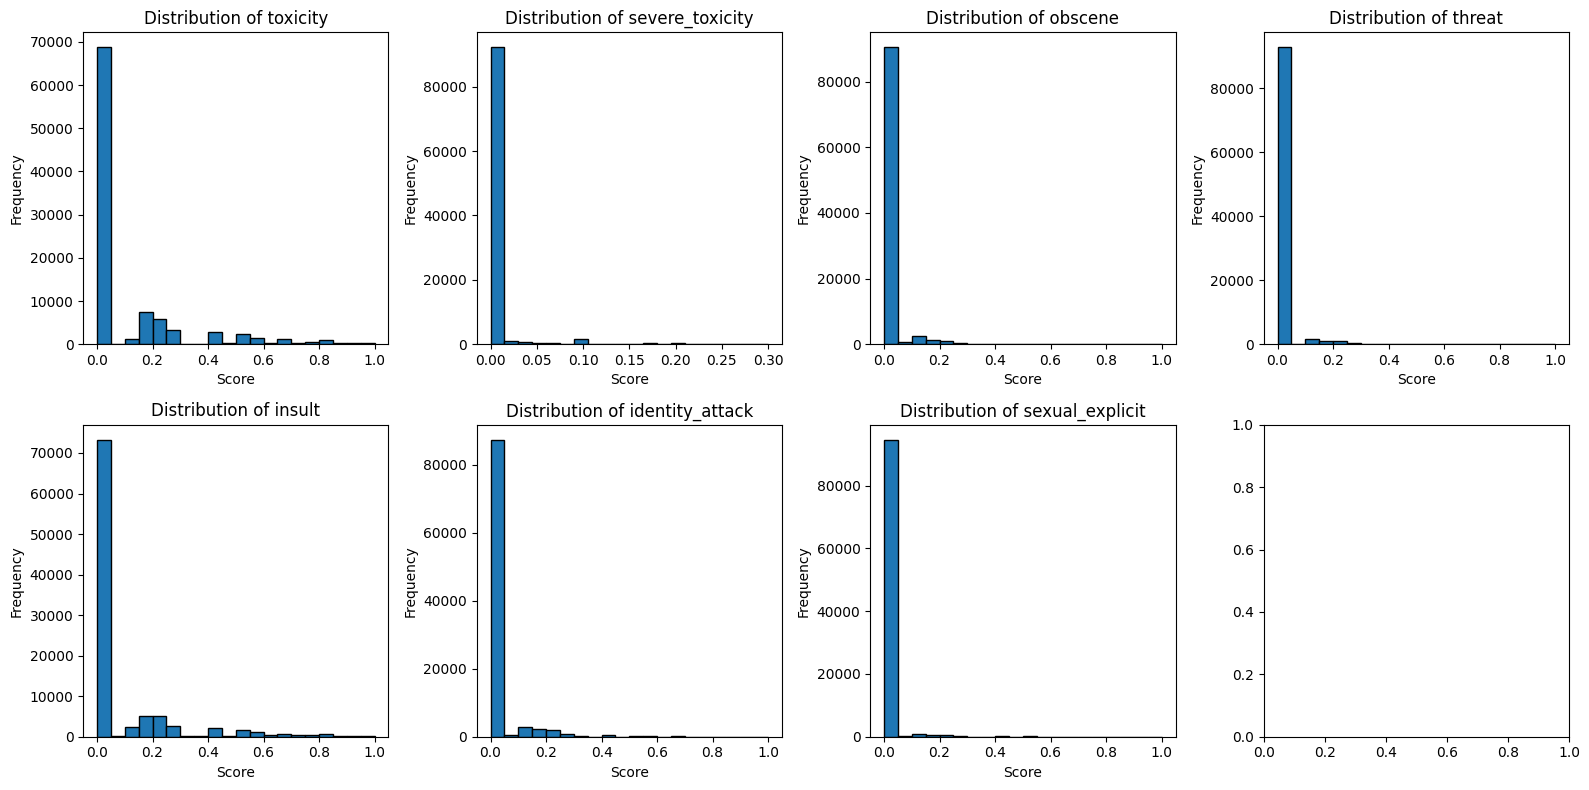

In [7]:
# Visualize tone distribution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(TONE_COLUMNS[:8]):
    if idx < len(TONE_COLUMNS):
        axes[idx].hist(df[col], bins=20, edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Generate Sentence Embeddings

In [8]:
# Load the sentence transformer model
print("Loading sentence transformer model...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Get model information
print(f"\nEmbedding dimension: {model.get_sentence_embedding_dimension()}")

Loading sentence transformer model...
Model loaded successfully!

Embedding dimension: 384


In [9]:
# Generate embeddings for all texts
print("Generating embeddings for all texts...")
texts = df[TEXT_COLUMN].tolist()
embeddings = model.encode(texts, show_progress_bar=True)
print(f"\nEmbeddings shape: {embeddings.shape}")

Generating embeddings for all texts...


Batches: 100%|██████████| 3042/3042 [04:19<00:00, 11.70it/s]



Embeddings shape: (97320, 384)


## 6. Prepare Training Data

In [10]:
# Prepare features (embeddings) and labels
X = embeddings
y = df[BINARY_COLUMNS].values  # Multi-label target

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Features shape: (97320, 384)
Labels shape: (97320, 7)

Training set size: 77856
Testing set size: 19464


In [11]:
# Standardize features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7. Train Multi-Label Classification Model

In [12]:
# Option 1: Random Forest Classifier
print("Training Random Forest Classifier...")
rf_classifier = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
rf_classifier.fit(X_train_scaled, y_train)
print("Random Forest training completed!")

Training Random Forest Classifier...
Random Forest training completed!


In [17]:
# Option 2: Logistic Regression (often works well with embeddings)
print("Training Logistic Regression Classifier...")
lr_classifier = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)
lr_classifier.fit(X_train_scaled, y_train)
print("Logistic Regression training completed!")

Training Logistic Regression Classifier...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

## 8. Model Evaluation

In [13]:
def evaluate_model(classifier, X_test, y_test, model_name):
    """Evaluate multi-label classification model"""
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    print(f"\n{'='*50}")
    print(f"Evaluation for {model_name}")
    print('='*50)
    
    # Calculate metrics for each label
    for idx, col in enumerate(BINARY_COLUMNS):
        print(f"\n{col}:")
        accuracy = accuracy_score(y_test[:, idx], y_pred[:, idx])
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test[:, idx], y_pred[:, idx], average='binary'
        )
        
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1:.3f}")
    
    # Overall accuracy
    overall_accuracy = np.mean([accuracy_score(y_test[:, i], y_pred[:, i]) 
                                for i in range(y_test.shape[1])])
    print(f"\nOverall Average Accuracy: {overall_accuracy:.3f}")
    
    return y_pred

In [15]:
# Evaluate Random Forest
rf_predictions = evaluate_model(rf_classifier, X_test_scaled, y_test, "Random Forest")

# Evaluate Logistic Regression
# lr_predictions = evaluate_model(lr_classifier, X_test_scaled, y_test, "Logistic Regression")


Evaluation for Random Forest

toxicity_binary:
  Accuracy: 0.921
  Precision: 0.800
  Recall: 0.005
  F1-Score: 0.010

severe_toxicity_binary:
  Accuracy: 1.000
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000

obscene_binary:
  Accuracy: 0.995
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000

threat_binary:
  Accuracy: 0.997
  Precision: 1.000
  Recall: 0.019
  F1-Score: 0.038

insult_binary:
  Accuracy: 0.940
  Precision: 0.900
  Recall: 0.008
  F1-Score: 0.015

identity_attack_binary:
  Accuracy: 0.993
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000

sexual_explicit_binary:
  Accuracy: 0.998
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000

Overall Average Accuracy: 0.978


## 9. Confusion Matrices Visualization

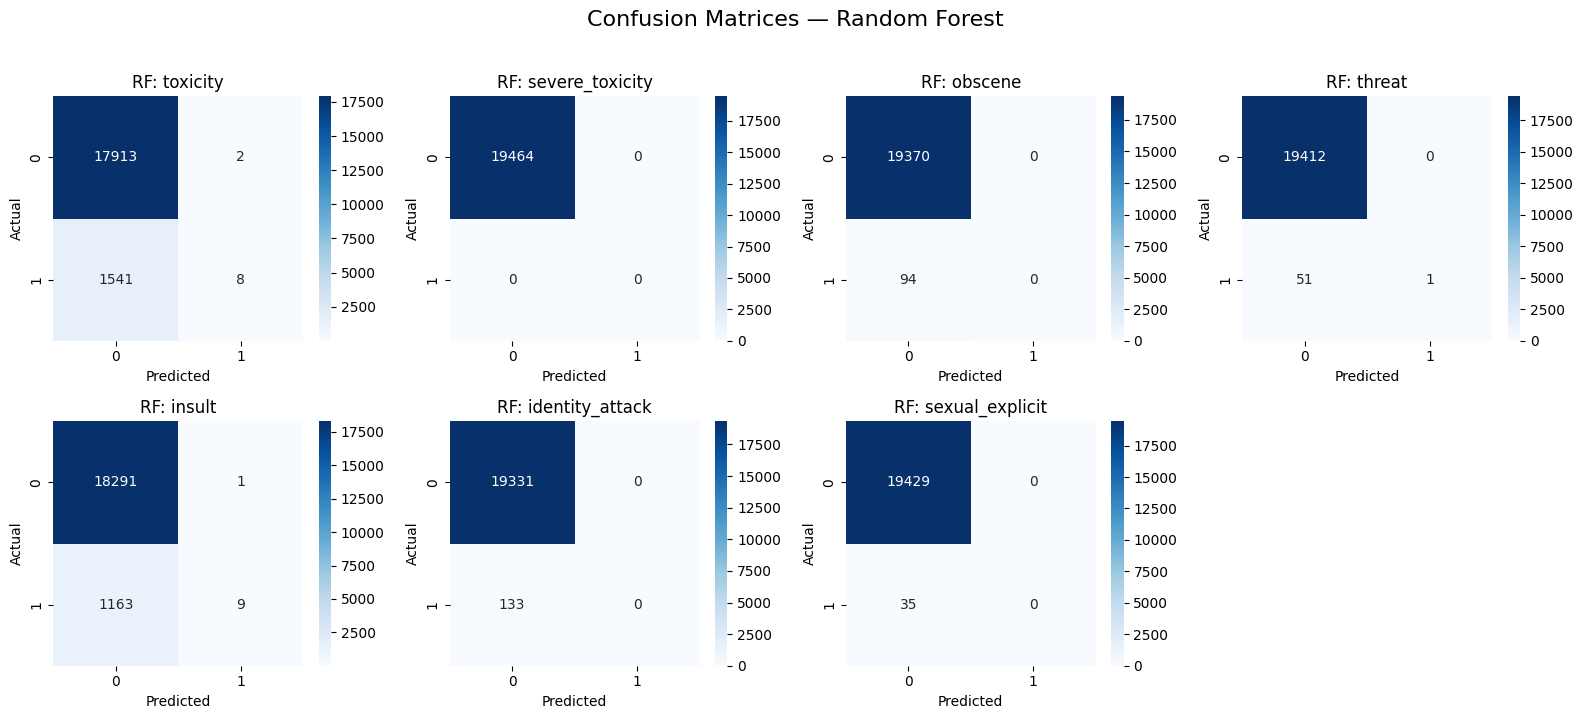

In [21]:
from math import ceil

n_labels = len(BINARY_COLUMNS)
ncols = 4                              # change if you prefer a different width
nrows = ceil(n_labels / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
axes = np.array(axes).reshape(-1)

for idx, col in enumerate(BINARY_COLUMNS):
    cm = confusion_matrix(y_test[:, idx], rf_predictions[:, idx], labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'RF: {col.replace("_binary","")}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Confusion Matrices — Random Forest', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 10. Save the Model and Components

In [18]:
# Save the best model (choose based on evaluation)
best_classifier = rf_classifier  # or rf_classifier based on performance

# Create a directory for model artifacts
os.makedirs('tone_model', exist_ok=True)

# Save the classifier
joblib.dump(best_classifier, 'tone_model/classifier.pkl')

# Save the scaler
joblib.dump(scaler, 'tone_model/scaler.pkl')

# Save column names
with open('tone_model/columns.txt', 'w') as f:
    f.write(','.join(BINARY_COLUMNS))

print("Model and components saved successfully!")

Model and components saved successfully!


## 11. Prediction Function for New Texts

In [22]:
class TonePredictor:
    def __init__(self, model_dir='tone_model'):
        import os
        os.environ["TRANSFORMERS_NO_TF"] = "1"   # avoid TensorFlow import issues
        os.environ["TOKENIZERS_PARALLELISM"] = "false"

        from sentence_transformers import SentenceTransformer
        import joblib

        self.sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

        self.classifier = joblib.load(f'{model_dir}/classifier.pkl')  # MultiOutputClassifier
        self.scaler = joblib.load(f'{model_dir}/scaler.pkl')

        with open(f'{model_dir}/columns.txt', 'r') as f:
            self.columns = f.read().split(',')

        # Sanity: estimators should match number of columns
        if hasattr(self.classifier, "estimators_"):
            if len(self.classifier.estimators_) != len(self.columns):
                raise ValueError(
                    f"Estimator count ({len(self.classifier.estimators_)}) != column count ({len(self.columns)}). "
                    "Make sure BINARY_COLUMNS saved at train time matches the fitted classifier."
                )

    def _positive_class_proba(self, estimator, X):
        """
        Return P(y=1) for a binary classifier, handling single-class training edge cases.
        """
        proba = estimator.predict_proba(X)  # shape: (n_samples, n_classes_seen)
        classes = getattr(estimator, "classes_", None)

        # If classes_ is available, use it to locate class 1
        if classes is not None:
            classes = np.asarray(classes)
            if classes.ndim == 0:  # very rare, but be safe
                classes = np.array([classes])

            if 1 in classes:
                pos_idx = int(np.where(classes == 1)[0][0])
                return proba[:, pos_idx]
            else:
                # Model never saw class 1 in training.
                # All outputs must be class 0 → P(y=1) = 0
                return np.zeros(proba.shape[0], dtype=float)

        # Fallback if classes_ missing:
        # If two columns, assume second is positive; if one, assume it's the only seen class = 0 (so prob=0)
        if proba.shape[1] == 2:
            return proba[:, 1]
        elif proba.shape[1] == 1:
            return np.zeros(proba.shape[0], dtype=float)
        else:
            # Unexpected shape; return zeros to be safe
            return np.zeros(proba.shape[0], dtype=float)

    def predict(self, texts, return_probabilities=False):
        import numpy as np
        import pandas as pd

        # Ensure list
        if isinstance(texts, str):
            texts = [texts]

        # Embeddings
        embeddings = self.sentence_model.encode(texts)
        embeddings_scaled = self.scaler.transform(embeddings)

        if return_probabilities:
            # Probabilities per label
            n_labels = len(self.columns)
            P = np.zeros((len(texts), n_labels), dtype=float)

            # Some MultiOutputClassifier impls store estimators_ after fitting
            if not hasattr(self.classifier, "estimators_"):
                raise AttributeError("Classifier does not have 'estimators_'. Was it fitted as MultiOutputClassifier?")

            for idx, est in enumerate(self.classifier.estimators_):
                P[:, idx] = self._positive_class_proba(est, embeddings_scaled)

            results = pd.DataFrame(P, columns=[c.replace('_binary', '_prob') for c in self.columns])

        else:
            # Binary predictions across labels
            Yhat = self.classifier.predict(embeddings_scaled)  # shape: (n_samples, n_labels)
            results = pd.DataFrame(Yhat, columns=[c.replace('_binary', '') for c in self.columns])

        results.insert(0, 'text', texts)
        return results


In [23]:
# Initialize the predictor
predictor = TonePredictor('tone_model')

# Example: Predict tone for new texts
sample_texts = [
    "This is a wonderful and positive message!",
    "I hate everything about this situation.",
    "The weather is nice today.",
    "You are completely worthless and stupid."
]

# Get binary predictions
predictions = predictor.predict(sample_texts)
print("Binary Predictions:")
print(predictions)

print("\n" + "="*50 + "\n")

# Get probability scores
probabilities = predictor.predict(sample_texts, return_probabilities=True)
print("Probability Scores:")
print(probabilities)

Binary Predictions:
                                        text  toxicity  severe_toxicity  \
0  This is a wonderful and positive message!         0                0   
1    I hate everything about this situation.         0                0   
2                 The weather is nice today.         0                0   
3   You are completely worthless and stupid.         0                0   

   obscene  threat  insult  identity_attack  sexual_explicit  
0        0       0       0                0                0  
1        0       0       0                0                0  
2        0       0       0                0                0  
3        0       0       0                0                0  


Probability Scores:
                                        text  toxicity_prob  \
0  This is a wonderful and positive message!       0.040000   
1    I hate everything about this situation.       0.140000   
2                 The weather is nice today.       0.130000   
3   You are com

## 12. Batch Prediction for Large Dataset

In [ ]:
def predict_batch(csv_file, output_file='predictions.csv', batch_size=32):
    """Predict tone for a large CSV file in batches"""
    # Load the data
    df_new = pd.read_csv(csv_file)
    
    # Initialize predictor
    predictor = TonePredictor('tone_model')
    
    # Process in batches
    all_predictions = []
    
    for i in range(0, len(df_new), batch_size):
        batch_texts = df_new[TEXT_COLUMN].iloc[i:i+batch_size].tolist()
        batch_predictions = predictor.predict(batch_texts, return_probabilities=True)
        all_predictions.append(batch_predictions)
        
        if i % 100 == 0:
            print(f"Processed {i}/{len(df_new)} texts...")
    
    # Combine all predictions
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    
    # Merge with original data
    result_df = pd.concat([df_new, final_predictions.drop('text', axis=1)], axis=1)
    
    # Save results
    result_df.to_csv(output_file, index=False)
    print(f"\nPredictions saved to {output_file}")
    
    return result_df

# Example usage (uncomment to run):
predictions_df = predict_batch('new_data.csv', 'tone_predictions.csv')

## 13. Feature Importance Analysis (for Random Forest)

In [ ]:
# Get feature importance for each tone classifier (Random Forest only)
if isinstance(rf_classifier.estimators_[0], RandomForestClassifier):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx, (estimator, col) in enumerate(zip(rf_classifier.estimators_, BINARY_COLUMNS[:8])):
        if idx < len(BINARY_COLUMNS):
            # Get top 10 important features
            importance = estimator.feature_importances_
            top_indices = np.argsort(importance)[-10:]
            
            axes[idx].barh(range(10), importance[top_indices])
            axes[idx].set_title(f'Top Features: {col.replace("_binary", "")}')
            axes[idx].set_xlabel('Importance')
    
    plt.suptitle('Feature Importance - Random Forest', fontsize=16)
    plt.tight_layout()
    plt.show()

## 14. Summary and Next Steps

### Model Performance Summary

This notebook has successfully:
1. ✅ Loaded and preprocessed the tone dataset
2. ✅ Generated sentence embeddings using all-MiniLM-L6-v2
3. ✅ Trained multi-label classification models
4. ✅ Evaluated model performance
5. ✅ Created a prediction pipeline for new texts

### Next Steps for Improvement:

1. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV to find optimal parameters
2. **Try Different Models**: Experiment with XGBoost, Neural Networks, or SVM
3. **Ensemble Methods**: Combine predictions from multiple models
4. **Class Imbalance**: If data is imbalanced, use SMOTE or class weights
5. **Feature Engineering**: Add additional features like text length, punctuation counts, etc.
6. **Fine-tune Embeddings**: Fine-tune the sentence transformer on your specific domain
7. **Cross-validation**: Implement k-fold cross-validation for more robust evaluation
8. **Threshold Optimization**: Optimize classification thresholds for each tone category

### Usage Instructions:

To use this model on your actual `civil_val.csv` file:
1. Place your CSV file in the same directory as this notebook
2. Ensure it has a 'text' column and tone columns
3. Run all cells in order
4. Use the `TonePredictor` class for making predictions on new texts